# makemore: part 5


https://arxiv.org/pdf/1609.03499

As we see there is no much difference between train loss and val loss, we can have some improvement with a bigger deeper architecture

However with our current model, the info of our 3 characters gets squased in the first layer. This creates an information bottleneck that limits the model's effectiveness.

![](mlp_squashing.png)

With the Wavenet proposal, information starts with 8 characters of context and flows progressively through multiple hidden layers

![](wavenet_architecture.png)

This creates a tree-like structure where:

* The bottom layer (dilation=1) processes local information
* Middle layers (dilation=2, 4) capture medium-range dependencies
* Top layer (dilation=8) captures longer-range contextual information


____

With the original archiquecture

![](current_arch_layers.png)

but now, we need our flatten layer to flattten every consecutive chacaters. Create a 4x4x20 instead a 4x80

![](new_flatten.png)

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#Data load. No changes here

#https://datos.gob.es/es/catalogo/a09002970-municipios-de-espana
# We will instead be using names of villages/cities in Spain. Only 8k data
import pandas as pd

# Read the CSV data
df = pd.read_csv("Municipis_d_Espanya.csv", sep=",")

# Function to clean the names
def clean_name(name):
    # If there's a slash, take the first part
    name = name.split('/')[0]
    # If it's in "Last, First" format, swap it to "First Last"
    if ',' in name:
        parts = name.split(', ')
        if len(parts) == 2:
            name = f"{parts[1]} {parts[0]}"
    return name

# Apply the function to clean names
df["Nom"] = df["Nom"].apply(clean_name)

# Extract only the 'Territorio' column as a list
words = df["Nom"].tolist()

print(f"{len(words)} words")

#Simplifying the problem (lowercase and no accents)
import unidecode
import re

print(words[:1])
words = [re.sub(r'[\(\)\'"]', '', unidecode.unidecode(word).lower()) for word in words]
print(words[:1])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

8134 words
['Alegría-Dulantzi']
['alegria-dulantzi']
{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}
29
torch.Size([85032, 8]) torch.Size([85032])
torch.Size([10606, 8]) torch.Size([10606])
torch.Size([10768, 8]) torch.Size([10768])


In [59]:
# These classes implement the same API as nn.Module in PyTorch

#--------------------------------------------------------------

class Linear:
    """Simple Linear layer implementation (y = wx + b)"""
    def __init__(self, fan_in, fan_out, bias=True):
        # Initialize weights using Kaiming initialization (scaled by fan_in)
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        # Forward pass: matrix multiplication (and bias addition if present)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # Return trainable parameters
        return [self.weight] + ([] if self.bias is None else [self.bias])

#--------------------------------------------------------------

class BatchNorm1d:
    """Batch Normalization layer for stabilizing training"""
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps  # Small constant for avoid /0
        self.momentum = momentum  # For running statistics update
        self.training = True
        # Learnable parameters
        self.gamma = torch.ones(dim)   # Scale parameter
        self.beta = torch.zeros(dim)   # Shift parameter
        # Running statistics for inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            # During training: use batch statistics
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
                    
            # Update running statistics for inference
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            # During inference: use running statistics
            xmean = self.running_mean
            xvar = self.running_var
        
        # Normalize and apply learnable parameters
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta          # Scale and shift
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#--------------------------------------------------------------
class Tanh:
    """Hyperbolic tangent activation function"""
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []  # No trainable parameters

In [60]:
# One more time doing it pytorch-like

# -----------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        # Create a learnable embedding table/matrix
        # num_embeddings: total number of unique tokens/items in vocabulary
        # embedding_dim: dimension of each embedding vector
        # shape: (vocabulary_size, embedding_dimension)
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        # IX is a tensor of indices into the embedding table
        # Each index selects a row from the embedding weight matrix
        # For example, if IX contains [3, 1, 4], this selects rows 3, 1, and 4
        # Returns tensor containing embedding vectors for each index
        self.out = self.weight[IX]
        return self.out
        
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------

class OldFlatten:      
    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out
        
    def parameters(self):
        # This layer has no learnable parameters
        return []
    
# -----------------------------------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):
        # n consecutive elements to be flattened
        self.consecutive_count = n
        
    def __call__(self, x):
        batch_size, context_length, feature_dim = x.shape

        x = x.view(batch_size, context_length//self.consecutive_count, feature_dim * self.consecutive_count)
        
        #self.out = x.view(batch_size, -1, feature_dim * self.consecutive_count) you can use view magic
        
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x

        return self.out
        
    def parameters(self):
        # This layer has no learnable parameters
        return []

In [61]:
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [62]:
# Model architecture parameters
n_embd = 10      # Dimension of character embeddings
n_hidden = 100   # Number of neurons in hidden layers

torch.manual_seed(42);


model = Sequential([
Embedding(vocab_size, n_embd),

FlattenConsecutive(2),
Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

FlattenConsecutive(2),
Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

FlattenConsecutive(2),
Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),

Linear(n_hidden, vocab_size, bias=False),
])


with torch.no_grad():
    # Scale down the last layer to make initial predictions less confident
    model.layers[-1].weight *= 0.1

# Collect all trainable parameters
#🧅parameters = '''[C]''' + [p for layer in layers for p in layer.parameters()]

#🏗️parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()#🏗️

print(sum(p.nelement() for p in parameters))  # Total number of parameters

# Enable gradient computation for all parameters
for p in parameters:
    p.requires_grad = True

#after wavenet: 18590 params

45790


In [63]:
ix= torch.randint(0, Xtr.shape[0],(4,))
Xb_example, Ybexample= Xtr[ix],Ytr[ix]
logits=model(Xb_example)

print(Xb_example.shape)

torch.Size([4, 8])


In [64]:
for layer in model.layers:
    print(layer.__class__.__name__, ": ", tuple(layer.out.shape))

Embedding :  (4, 8, 10)
FlattenConsecutive :  (4, 4, 20)
Linear :  (4, 4, 100)
BatchNorm1d :  (4, 4, 100)
Tanh :  (4, 4, 100)
FlattenConsecutive :  (4, 2, 200)
Linear :  (4, 2, 100)
BatchNorm1d :  (4, 2, 100)
Tanh :  (4, 2, 100)
FlattenConsecutive :  (4, 200)
Linear :  (4, 100)
BatchNorm1d :  (4, 100)
Tanh :  (4, 100)
Linear :  (4, 29)


![](arch_example.png)

In [65]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 100])

In [66]:
# Training hyperparameters
max_steps = 200000
batch_size = 32
lossi = []  # Store loss history (log10)

for i in range(max_steps):
    
    # Create minibatch by random sampling
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of inputs and targets
    
    # Forward pass--->
    x=Xb
    #🧅emb = C[Xb]  # Transform characters into embedding vectors
    #🧅x = emb.view(emb.shape[0], -1)  # Flatten the embeddings for the linear layer
    
    #🏗️for layer in layers:
    #🏗️    x = layer(x)  # Pass through each layer sequentially
    

    logits=model(x)#🏗️
    
    loss = F.cross_entropy(logits, Yb)  # Calculate cross entropy loss
    
    # Backward pass<----  
    # Zero all parameter gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Parameter update with learning rate decay
    lr = 0.1 if i < 150000 else 0.01  # Reduce learning rate after 150k steps. Commenting this after bad results
    for p in parameters:
        p.data += -lr * p.grad  # Simple SGD update
    
    # Monitoring and logging
    if i % 5000 == 0:  # Print progress every 5k steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Store loss in log scale
    lossi.append(loss.log10().item())


      0/ 200000: 3.3594
   5000/ 200000: 1.8366
  10000/ 200000: 1.4623
  15000/ 200000: 1.9564
  20000/ 200000: 1.3715
  25000/ 200000: 2.0456
  30000/ 200000: 1.4536
  35000/ 200000: 1.8008
  40000/ 200000: 1.2506
  45000/ 200000: 1.2791
  50000/ 200000: 1.5970
  55000/ 200000: 1.3768
  60000/ 200000: 1.6184
  65000/ 200000: 1.6020
  70000/ 200000: 1.1701
  75000/ 200000: 2.0170
  80000/ 200000: 1.5436
  85000/ 200000: 1.1655
  90000/ 200000: 2.1838
  95000/ 200000: 1.5454
 100000/ 200000: 1.4235
 105000/ 200000: 1.3006
 110000/ 200000: 1.3784
 115000/ 200000: 1.2635
 120000/ 200000: 1.5075
 125000/ 200000: 1.5222
 130000/ 200000: 1.3959
 135000/ 200000: 1.1974
 140000/ 200000: 1.4529
 145000/ 200000: 1.5525
 150000/ 200000: 1.1690
 155000/ 200000: 1.2456
 160000/ 200000: 1.2492
 165000/ 200000: 1.5798
 170000/ 200000: 1.3377
 175000/ 200000: 1.6136
 180000/ 200000: 1.1365
 185000/ 200000: 1.0328
 190000/ 200000: 1.5498
 195000/ 200000: 0.8902


_______________________

In [72]:
for layer in model.layers:
    layer.training=False

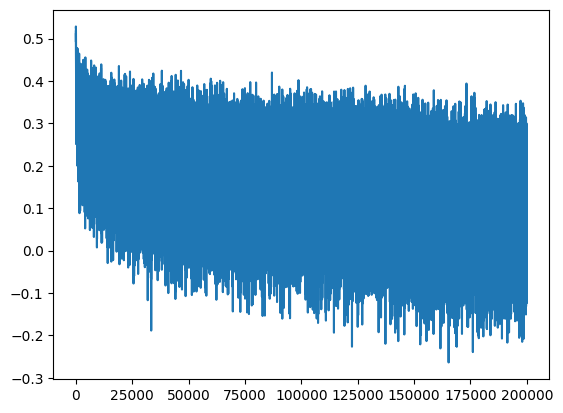

In [68]:
#probably our batch size is too small. we got lucky batches or unlucky batches

plt.plot(lossi)

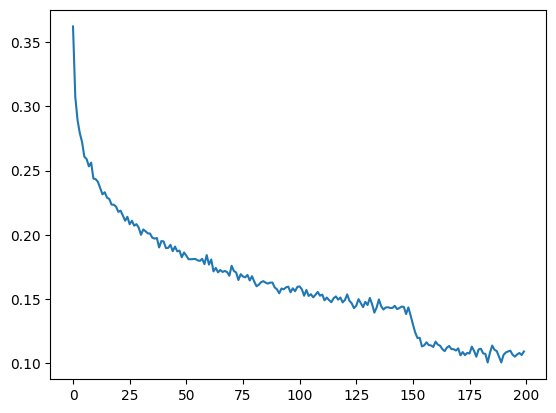

In [69]:
#🌫️ Fixing loss plot

lossi_tensor=torch.tensor(lossi)
# Reshape the tensor and calculate mean values for plotting:
# view(-1, 1000) reshapes the tensor into rows of 1000 values each
# mean(1) calculates the mean along dimension 1 (across each row)
#    - This gives you the average loss for each group of 1000 iterations
plt.plot(lossi_tensor.view(-1,1000).mean(1))

In [70]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    
    #🏗️ emb = C[x] # (N, block_size, n_embd)
    #🏗️ x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    #🏗️ for layer in layers:
    #🏗️     x=layer(x)
    #🏗️ loss=F.cross_entropy(x,y)

    #🏗️
    logits=model(x)
    loss=F.cross_entropy(logits,y)

    print(split,loss.item())

split_loss('train')
split_loss('val')

train 1.2104228734970093
val 1.7336194515228271


Overfitted losses:

train 0.7902982234954834

val 2.096215009689331

In [71]:
for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #🏗️ emb = C[torch.tensor([context])] # (1,block_size,d)
        #🏗️ x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        #🏗️ for layer in layers:
        #🏗️     x=layer(x)
        logits=model(torch.tensor([context]))
        probs= F.softmax(logits,dim=1)

        ix=torch.multinomial(probs, num_samples=1).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

granon.
bulanes.
aldealeran.
villamontan.
guares.
bremerinos.
encinas de san juan.
illano.
bastell de la serondayo de tajuna.
castellots de bureba.
viveria.
valle de istar.
caniz-quentes.
mayillas.
adrona.
duena.
quintanillas.
cadas.
mendariz.
blanca.
valverdella.
torrecilla del prino.
calvados.
mazquita.
castrobon.
retee-izsalaz.
cacas malancsena.
villamoros.
aguilar del i omonil.
cabra debila.
manchana de diebes.
ciruena.
guadala.
sigarras.
castellar de santa maria de roso.
colesteo.
la viejo.
azarezes.
fislayo.
vallfovica.
masillafronca del monte.
san antonio de zalory.
villela.
la iguia.
artajada.
santa maria de roso.
madartal de benis.
tirgo.
gellugal.
la villa.
massal-jaramuna.
el castreciernal.
abanos de la tormes.
alhama de alamura.
sant marti sapalongorriba.
les tobal de alba.
valmormas.
belatame.
zagaconas.
gozote.
montcladena.
castrillo de torra.
sant mitares.
montariba.
pusulludon.
chujarilla.
piedra alamudio.
morerenas.
cabra.
villaliga.
salmeron.
bubila.
borauxea de la si

Overfitted results

train 0.7902982234954834

val 2.096215009689331

nhidden = 200

batch_size=64

```
artazu.
cardenosa.
bujalance.
sondija.
mijas.
navalperal de los infantes.
villaralbo.
guardamar del segura.
aldehuela de tubo.
barbadillo del egruebo.
abos de valdeque del retamar.
becedes.
villamuriel de cerreros.
la seco.
ador.
plasencia.
castro de filabrameni.
ragona.
hinojosa del rio.
villamandos.
pedrosa del campo.
rionegro del pinar.
la linea de gata.
pont de molindres.
la cabrete.
munipe.
marracos.
clarante.
colinos.
geda.
caniles.
san cristobal de entrevinas de riglos.
alaro.
la lloseja.
penacinos.
monforte de litera.
ragamaler.
verdesa.
rezmondo.
sobremunt.
a pobra do brollon.
valdeltorme.
santa colomba de mar.
bidana.
castellanos de molgas.
santibanez el alto.
la zaida.
rafalba.
alcala de sepulveda de don fadrique.
valencia de don juan.
muelas del campo.
singra.
barbunale.
o munomel del pinar.
canyelles.
villel.
ereno.
lucillo.
ferreira.
valencia de almazan.
villanueva de san vicente.
benquistal.
brazas.
sayatell.
el ronquillo.
martin de la polante de las matas.
villafranca de belena.
montoba.
cerecinos del rey.
cabeza del arzobispo.
cabranes.
paquer.
bescarza.
canillas de san silvestre.
alhaurin de la torre de les garrs de la jara.
villafranca de tajo.
los realent.
revilla vallejera.
escorca.
juia.
fuentes de malago de calatrava.
arraya de oca.
erandio.
portizo.
brea de aragona.
manganeses de pela.
zarza de salvatierra.
almudaina.
benijofar.
valle de bardaji.
el pont de montalgrao.
els palwses.
arevalillo de los caballeros.
valdegrudas.
el hiruelos.
amurrio.
villanueva de perianez.
alfaules.
fuentelespino de toranzo.
tosos.
```